<a href="https://colab.research.google.com/github/wndlovu/EGGS-Aquacrop/blob/main/irrigation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install aquacrop==0.2
!pip install aquacrop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent
#from aquacrop.utils import prepare_weather, get_filepath
from aquacrop.classes import    *
from aquacrop.core import       *


from google.colab import output
output.clear()
import pandas as pd
import sys
import seaborn as sns
_=[sys.path.append(i) for i in ['.', '..']]

In [ ]:
# determine soil type
soils = pd.read_csv(get_filepath("/content/drive/MyDrive/gridMET/Soil_FieldsAroundSD6KS_POLARIS_AGrinstead_20220706.csv"))
soils = soils[soils['UID'] == 1381151]
soils 

,Unnamed: 0,UID,depth_cm,silt_prc,sand_prc,clay_prc,thetaS_m3m3,thetaR_m3m3,logKsat_cmHr,lambda,logHB_kPa,n,logAlpha_kPa1
10631,10631,1381151,0-5,51.05,26.16,19.23,0.50,0.06,0.07,0.32,0.31,1.35,-0.31
21945,21945,1381151,5-15,50.17,25.09,21.00,0.50,0.06,0.06,0.31,0.32,1.35,-0.30
33259,33259,1381151,15-30,49.66,20.71,25.35,0.51,0.06,-0.00,0.29,0.33,1.31,-0.32
44573,44573,1381151,30-60,51.47,17.37,26.81,0.52,0.07,-0.01,0.29,0.37,1.30,-0.36
55887,55887,1381151,60-100,52.80,19.76,22.20,0.50,0.06,0.05,0.31,0.37,1.32,-0.36
67201,67201,1381151,100-200,50.54,27.13,17.08,0.50,0.05,0.22,0.34,0.25,1.37,-0.26


In [ ]:
weather_file_path = get_filepath('/content/drive/MyDrive/gridMET/gridMET_1381151.txt')

path = get_filepath('/content/drive/MyDrive/gridMET/gridMET_1381151.txt')
wdf = prepare_weather(path)
sim_start = '2000/01/01' #dates to match crop data
sim_end = '2015/12/31'
soil= SoilClass('Loam')
crop = CropClass('Maize',PlantingDate='05/01')
initWC = InitWCClass(value=['FC'])

In [ ]:
# soil water thresholds by soil type
#https://extension.okstate.edu/fact-sheets/understanding-soil-water-content-and-thresholds-for-irrigation-management.html#:~:text=of%20Oklahoma%20soils.-,Soil%20Water%20Thresholds,how%20much%20irrigation%20is%20needed.
labels=[]

outputs=[]
for smt in range(0,110,20):
    crop.Name = str(smt) # add helpfull label
    labels.append(str(smt))
    irr_mngt = IrrMngtClass(IrrMethod=1,SMT=[40,60,70,30]*4) # specify irrigation management [40,60,70,30]*4
    model = AquaCropModel(sim_start,sim_end,wdf,soil,crop,InitWC=initWC,IrrMngt=irr_mngt) # create model
    model.initialize() # initilize model
    model.step(till_termination=True) # run model till the end
    outputs.append(model.Outputs.Final) # save results
all_outputs = pd.concat(outputs)


all_outputs

# SMT - 'Soil moisture targets (%TAW) to maintain in each growth stage' (emergence, canopy growth, max canopy, canopy senescence)

,Season,Crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,0,2000-09-03,245,12.082880,325.0
1,1,0,2001-09-04,611,12.095454,275.0
2,2,0,2002-09-01,973,11.803963,425.0
3,3,0,2003-09-08,1345,12.438089,375.0
4,4,0,2004-09-14,1717,13.446805,200.0
...,...,...,...,...,...,...
11,11,100,2011-08-31,4259,11.838380,275.0
12,12,100,2012-08-26,4620,11.438786,450.0
13,13,100,2013-09-04,4994,12.299967,325.0
14,14,100,2014-09-10,5365,13.106397,275.0


In [ ]:
# not ideal because it removes the year

#import pandas as pd

#dflist=outputs
#labels[0]='Rainfed'
#outlist=[]
#for i in range(len(dflist)):
    #temp = pd.DataFrame(dflist[i][['Yield (tonne/ha)',
                                   #'Seasonal irrigation (mm)']])
    #temp['label']=labels[i]
    #outlist.append(temp)

#all_outputs = pd.concat(outlist)

In [ ]:
# check model to see what the irrigation values are for one year
x = all_outputs[all_outputs['Harvest Date (YYYY/MM/DD)'] == '2000-09-03']
x

In [ ]:
#print(all_outputs)
irrig_aqc = all_outputs.assign(Year =  all_outputs['Harvest Date (YYYY/MM/DD)'].dt.year)
irrig_aqc = irrig_aqc.pivot(index= 'Year', # show irrigation vals for each year horizontally
                             columns='Crop Type', 
                             values='Seasonal irrigation (mm)')
irrig_aqc.reset_index(inplace=True)       # make year a column 
#yield_df.rename(columns={'0': "SMT 0%"}) 
                         #"100": "SMT 100%",
                         #"20": "SMT 20%", 
                         #"40": "SMT 40%", 
                         #"60": "SMT 60%", 
                         #"80": "SMT 80%"})                                                                  

irrig_aqc = irrig_aqc[irrig_aqc['Year'] >= 2006]
irrig_aqc

In [ ]:
# upload the Water rights files 
wr_groups = pd.read_csv("/content/drive/MyDrive/gridMET/WRgroups_FieldByYear.csv")
water_use = pd.read_csv("/content/drive/MyDrive/gridMET/WRgroups_UseByWRG.csv")


In [ ]:
irrig_wimas = pd.merge(wr_groups, water_use, on=["WR_GROUP", "Year"]) # 
irrig_wimas = irrig_wimas[irrig_wimas['UID'] == 	1381151] # filter for field
irrig_wimas = irrig_wimas[irrig_wimas['Year'] <= 	2015]
irrig_wimas = irrig_wimas.assign(irrig_wimas_mm = (irrig_wimas['Irrigation_m3']/(irrig_wimas['TRGT_ACRES']*4046.86))*1000)
irrig_wimas

In [ ]:
irrig_df = pd.merge(irrig_wimas, irrig_aqc, on=["Year", "Year"])
irrig_df  = irrig_df[['UID', 'Year', 'Irrigation_m3', 'irrig_wimas_mm', '0', '20', '40', '60', '80', '100']]
irrig_df

#irrig_df.to_csv('irrig_df.csv', index=False)

Text(0.5, 0, 'Soil-moisture threshold (%TAW)')

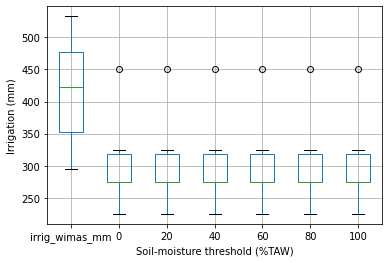

In [ ]:
boxplot = irrig_df.boxplot(column=['irrig_wimas_mm', '0', '20', '40', '60', '80', '100'])
boxplot.set_ylabel('Irrigation (mm)')
boxplot.set_xlabel('Soil-moisture threshold (%TAW)')

In [ ]:
aqc_df = all_outputs.assign(Year =  all_outputs['Harvest Date (YYYY/MM/DD)'].dt.year)
aqc_df = aqc_df[aqc_df['Year'] >= 2006]
irrig_df_unpivoted = pd.merge(aqc_df, irrig_wimas, on=["Year", "Year"])
irrig_df_unpivoted

In [ ]:
# yield data from usda nass https://quickstats.nass.usda.gov/#D93A3218-8B77-31A6-B57C-5A5D97A157D8
yield_Irrig = pd.read_csv("/content/drive/MyDrive/gridMET/sheridanYield_Irrig.csv") #CORN, GRAIN, YIELD, MEASURED IN BU / ACRE
yield_noIrrig = pd.read_csv("/content/drive/MyDrive/gridMET/sheridanYield_noIrrig.csv") #CORN, GRAIN, IRRIGATED - YIELD, MEASURED IN BU / ACRE

In [ ]:
yield_Irrig = yield_Irrig[['Year', 'Value']]
yield_noIrrig = yield_noIrrig[['Year', 'Value']]

In [ ]:
yield_df = all_outputs.assign(Year =  all_outputs['Harvest Date (YYYY/MM/DD)'].dt.year)
yield_df = yield_df.pivot(index= 'Year', # show irrigation vals for each year horizontally
                             columns='Crop Type', 
                             values='Yield (tonne/ha)')
yield_df = pd.merge(yield_df, yield_Irrig, on=["Year", "Year"])
yield_df = yield_df.assign(YieldUSDA = yield_df['Value']*0.0673) # convert yield from bushels/acre to tonne/ha
yield_df

yield_df.to_csv('yield_df.csv', index=False)

Text(0.5, 0, 'Soil-moisture threshold (%TAW)')

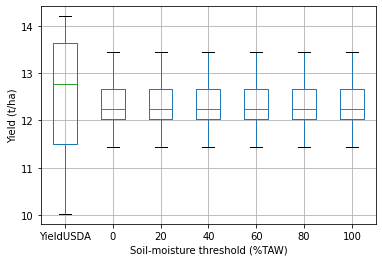

In [ ]:
boxplot = yield_df.boxplot(column=['YieldUSDA', '0', '20', '40', '60', '80', '100'])
boxplot.set_ylabel('Yield (t/ha)')
boxplot.set_xlabel('Soil-moisture threshold (%TAW)')

In [ ]:
yield_df_unpivoted = pd.merge(aqc_df, yield_Irrig, on=["Year", "Year"])
yield_df_unpivoted = yield_df_unpivoted.assign(YieldUSDA = yield_df_unpivoted['Value']*0.0673)
yield_df_unpivoted

,Season,Crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm),Year,Value,YieldUSDA
0,6,0,2006-09-01,2434,11.965456,325.0,2006,155.0,10.43150
1,6,20,2006-09-01,2434,11.965456,325.0,2006,155.0,10.43150
2,6,40,2006-09-01,2434,11.965456,325.0,2006,155.0,10.43150
3,6,60,2006-09-01,2434,11.965456,325.0,2006,155.0,10.43150
4,6,80,2006-09-01,2434,11.965456,325.0,2006,155.0,10.43150
5,6,100,2006-09-01,2434,11.965456,325.0,2006,155.0,10.43150
6,7,0,2007-09-01,2799,12.051854,275.0,2007,206.0,13.86380
7,7,20,2007-09-01,2799,12.051854,275.0,2007,206.0,13.86380
8,7,40,2007-09-01,2799,12.051854,275.0,2007,206.0,13.86380
9,7,60,2007-09-01,2799,12.051854,275.0,2007,206.0,13.86380


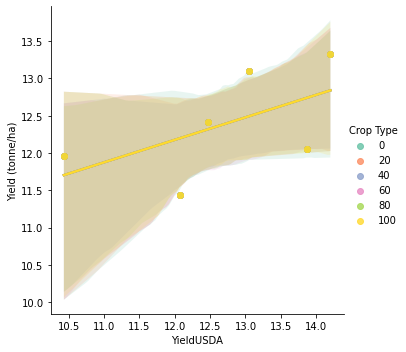

In [ ]:
plot = sns.lmplot(y='Yield (tonne/ha)', 
           x='YieldUSDA', 
           data=yield_df_unpivoted,
           hue='Crop Type',
           palette="Set2",
           fit_reg=True)